#### Bag of Words, Bag of CUIs Approaches:
In this notebook I am using bag of words (BoW) and bag of Concept Unique Identifiers (CUIs) that I have extracted using cTAKES to predict 30-day unplanned readmission.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import pickle
import warnings
warnings.filterwarnings('ignore')

In [169]:
 df_adm_notes_clean = pd.read_pickle('Prepared_Data.pkl')

In [170]:
df_adm_notes_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51113 entries, 1 to 58975
Data columns (total 12 columns):
SUBJECT_ID             51113 non-null int64
HADM_ID                51113 non-null int64
ADMITTIME              51113 non-null datetime64[ns]
DISCHTIME              51113 non-null datetime64[ns]
DEATHTIME              5792 non-null datetime64[ns]
ADMISSION_TYPE         51113 non-null object
NEXT_ADMITTIME         11169 non-null datetime64[ns]
NEXT_ADMISSION_TYPE    11169 non-null object
DAYS_NEXT_ADMIT        11169 non-null float64
CATEGORY               49083 non-null object
TEXT                   49083 non-null object
OUTPUT_LABEL           51113 non-null int64
dtypes: datetime64[ns](4), float64(1), int64(3), object(4)
memory usage: 5.1+ MB


#### I have extracted CUIs of diseases and disorders for each patient using cTAKES and Scala. Here I read this information from a csv file and save it in df_cuis dataframe.

In [171]:
df_cuis = pd.read_csv('WithCuis_P.csv', engine = "c")

#### Lets see how this dataframe looks like:

In [172]:
df_cuis.head()

,SUBJECT_ID_T,HADM_ID_T,CUIS
0,3,145834,NaN
1,4,185777,C0021051
2,6,107064,C0022661 C2316810 C0022658 C0012634
3,9,150750,C0406810
4,11,194540,C0020517


#### Some discharge notes don't have any disease and disorder CUIs. I fill these NaNs with an empty string.

In [173]:
df_cuis.fillna(" ", inplace= True)

In [174]:
df_cuis.columns = ["SUBJECT_ID", "HADM_ID", "CUIS"]

#### Merging two dataframes:

In [175]:
df_adm_notes_clean = pd.merge(df_adm_notes_clean, df_cuis, on = ['SUBJECT_ID','HADM_ID'],how = 'left')

#### Shuffling the samples

In [176]:
df_adm_notes_clean = df_adm_notes_clean.sample(n = len(df_adm_notes_clean), random_state = 42)

In [177]:
df_adm_notes_clean = df_adm_notes_clean.reset_index(drop = True)

#### Save 20% of the data for validation:

In [178]:
df_valid = df_adm_notes_clean.sample(frac=0.2,random_state=42)

In [179]:
df_valid.to_pickle('df_valid.pkl')

In [180]:
df_train_all=df_adm_notes_clean.drop(df_valid.index)

#### As I mentioned in preparation section, data is highly imbalanced. I am going to do down sampling for negative cases:

In [181]:
rows_pos = df_train_all.OUTPUT_LABEL == 1
df_train_pos = df_train_all.loc[rows_pos]
df_train_neg = df_train_all.loc[~rows_pos]

#### Making a balanced dataset (50/50):

In [182]:
df_train = pd.concat([df_train_pos, df_train_neg.sample(n = len(df_train_pos), random_state = 42)],axis = 0)

#### Shuffling before training:

In [183]:
df_train = df_train.sample(n = len(df_train), random_state = 42).reset_index(drop = True)

In [184]:
df_train.to_pickle('df_train.pkl')

#### Preprocess for bag-of-words (BoF):

In [23]:
def preprocess_text(df):
    # This function preprocesses the text by filling not a number and replacing new lines ('\n') and carriage returns ('\r')
    df.TEXT = df.TEXT.fillna(' ')
    df.TEXT = df.TEXT.str.replace('\n',' ')
    df.TEXT = df.TEXT.str.replace('\r',' ')
    return df

In [24]:
df_train = preprocess_text(df_train)
df_valid = preprocess_text(df_valid)

In [122]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
from nltk import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.util import ngrams
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer


# sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB

from numpy import array
from scipy.sparse import csr_matrix
from time import time
import re
import string


# keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.optimizers import Adam
from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.callbacks import TensorBoard
from keras.utils import np_utils
from keras.utils import to_categorical

[nltk_data] Downloading package punkt to /home/ssarafrazi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/ssarafrazi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


#### Now lets look at one of the texts:

In [26]:
df_train.TEXT[0]

"Admission Date:  [**2107-7-19**]     Discharge Date:  [**2107-7-31**]  Date of Birth:   [**2051-5-31**]     Sex:  M  Service:  COLORECTAL SURGERY/GREEN SURGERY  HISTORY OF PRESENT ILLNESS:  This is a 56-year-old man with a history of ulcerative colitis since [**2098**].  The patient was hospitalized almost annually for flareups.  His current flare began three weeks ago at which time he was admitted to [**Hospital3 9683**] for the past three weeks.  He was recently started on IV hydrocortisone and sent home several days prior this admission.  The patient complained of increasing symptoms over the weekend with severe lower abdominal pain with po intake, low grade fevers, nausea, vomiting, and [**6-26**] bloody bowel movements per day.  PAST MEDICAL HISTORY:  Ulcerative colitis.  PAST SURGICAL HISTORY:  None.  MEDICATIONS: 1. Hydrocortisone 100 mg tid. 2. Two Ativan prn. 3. Iron. 4. Folic acid. 5. Prevacid.  ALLERGIES:  6-mercaptopurine, reaction jaundice.  SOCIAL HISTORY:  No tobacco an

#### These texts need lots of cleaning:

In [27]:
def clean_text(text):

    punc_list = string.punctuation+'0123456789'
    t = str.maketrans(dict.fromkeys(punc_list, " "))
    text = text.lower().translate(t).split()
    
    ## Remove stop words
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops and len(w) >= 3]
    text = " ".join(text)
    
    ## Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)
    
    ## Stemming
    text = text.split()
    stemmer = SnowballStemmer('english')
    stemmed_words = [stemmer.stem(word) for word in text]
    text = " ".join(stemmed_words)
    
    return text

#### Now lets see how they look:

In [28]:
clean_text(df_train['TEXT'][0])

'admiss date discharg date date birth sex servic colorect surgeri green surgeri histori present ill year old man histori ulcer coliti sinc patient hospit almost annual flareup current flare began three week ago time admit hospit past three week recent start hydrocortison sent home sever day prior admiss patient complain increas symptom weekend sever lower abdomin pain intak low grade fever nausea vomit bloodi bowel movement per day past medic histori ulcer coliti past surgic histori none medic hydrocortison tid two ativan prn iron folic acid prevacid allergi mercaptopurin reaction jaundic social histori tobacco occasion alcohol famili histori mother name diseas review system chest pain short breath palpit dysuria hematuria hematemesi physic examin admiss vital sign temperatur heart rate blood pressur respir puls oxygen room air alert orient time three acut distress sclera anicter mucous membran moist heart rate regular rate rhythm murmur rub gallop lung clear auscult bilater abdomen so

#### Looks clean and ready for BoW!

In [30]:
df_train['TEXT'] = df_train['TEXT'].map(lambda x: clean_text(x))
df_valid['TEXT'] = df_valid['TEXT'].map(lambda x: clean_text(x))

#### Now I want to add polarized CUIs to texts:

In [31]:
df_train['TEXT_CUIS']= df_train.TEXT + " " + df_train.CUIS
df_valid['TEXT_CUIS']= df_valid.TEXT + " " + df_valid.CUIS

In [32]:
df_train.TEXT_CUIS[0]

'admiss date discharg date date birth sex servic colorect surgeri green surgeri histori present ill year old man histori ulcer coliti sinc patient hospit almost annual flareup current flare began three week ago time admit hospit past three week recent start hydrocortison sent home sever day prior admiss patient complain increa symptom weekend sever lower abdomin pain intak low grade fever nausea vomit bloodi bowel movement per day past medic histori ulcer coliti past surgic histori none medic hydrocortison tid two ativan prn iron folic acid prevacid allergi mercaptopurin reaction jaundic social histori tobacco occas alcohol famili histori mother name disea review system chest pain short breath palpit dysuria hematuria hematemesi physic examin admiss vital sign temperatur heart rate blood pressur respir pul oxygen room air alert orient time three acut distress sclera anict mucous membran moist heart rate regular rate rhythm murmur rub gallop lung clear auscult bilat abdomen soft tender 

#### As you can see CUIs are attached to the texts.

I will use the built in CountVectorizer from scikit-learn package. This vectorizer simply counts how many times each word occurs in the note. There is also a TfidfVectorizer which takes into account how often words are used across all notes, that I use later.

In [33]:
vocabulary_size = 20000

In [37]:
vect = CountVectorizer(max_features = 50000)
vect.fit(df_train.TEXT_CUIS.values)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=50000, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [38]:
X_train_tf = vect.transform(df_train.TEXT_CUIS.values)

#### Finding most frequent words to use them as Stop-Words:¶

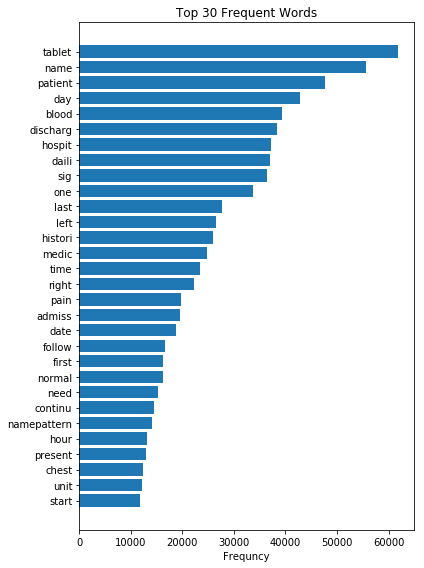

In [39]:
sum_words = X_train_tf.sum(axis=0) 
words_freq = [(word, sum_words[0, idx]) for word, idx in     vect.vocabulary_.items()]
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
words_freq_plot = words_freq[:30]
values = [value[0] for value in words_freq_plot]
freq = [value[1] for value in words_freq_plot]
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (6,8), sharex=True)
plt.barh(range(len(values)),freq, align = 'center')
plt.yticks(range(len(values)),values)
plt.title("Top 30 Frequent Words")
plt.gca().invert_yaxis()
plt.xlabel('Frequncy')
plt.tight_layout()
plt.show()

#### We can see the most frequent words. Now we can make our own stop words:

In [41]:
my_stop_words = ['the','and','to','of','was','with','a','on','in','for','name',
                 'is','patient','s','he','at','as','or','one','she','his','her','am',
                 'were','you','pt','pm','by','be','had','your','this','date',
                 'from','there','an','that','p','are','have','has','h','but','o',
                 'namepattern','which','every','also']

### Making BoW using the TEXT column:

In [101]:
vect = CountVectorizer(max_features = 50000,  
                       stop_words = my_stop_words)
vect.fit(df_train.TEXT.values)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=50000, min_df=1,
        ngram_range=(1, 1), preprocessor=None,
        stop_words=['the', 'and', 'to', 'of', 'was', 'with', 'a', 'on', 'in', 'for', 'name', 'is', 'patient', 's', 'he', 'at', 'as', 'or', 'one', 'she', 'his', 'her', 'am', 'were', 'you', 'pt', 'pm', 'by', 'be', 'had', 'your', 'this', 'date', 'from', 'there', 'an', 'that', 'p', 'are', 'have', 'has', 'h', 'but', 'o', 'namepattern', 'which', 'every', 'also'],
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [102]:
X_train_text_tf = vect.transform(df_train.TEXT.values)
X_valid_text_tf = vect.transform(df_valid.TEXT.values)

# Response:

y_train = df_train.OUTPUT_LABEL
y_valid = df_valid.OUTPUT_LABEL

### Making Bag of Words (BoW) and Bag of CUIs (BoC) using TEXT_CUIS column:

In [42]:
vect = CountVectorizer(max_features = 50000,  
                       stop_words = my_stop_words)
                       #ngram_range= (1,3))
vect.fit(df_train.TEXT_CUIS.values)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=50000, min_df=1,
        ngram_range=(1, 1), preprocessor=None,
        stop_words=['the', 'and', 'to', 'of', 'was', 'with', 'a', 'on', 'in', 'for', 'name', 'is', 'patient', 's', 'he', 'at', 'as', 'or', 'one', 'she', 'his', 'her', 'am', 'were', 'you', 'pt', 'pm', 'by', 'be', 'had', 'your', 'this', 'date', 'from', 'there', 'an', 'that', 'p', 'are', 'have', 'has', 'h', 'but', 'o', 'namepattern', 'which', 'every', 'also'],
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [43]:
X_train_tf = vect.transform(df_train.TEXT_CUIS.values)
X_valid_tf = vect.transform(df_valid.TEXT_CUIS.values)

### TF-IDF using TEXT_CUIS column:

In [45]:
vect_TF_IDF = TfidfVectorizer(stop_words = my_stop_words)
vect_TF_IDF.fit(df_train.TEXT_CUIS.values)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=['the', 'and', 'to', 'of', 'was', 'with', 'a', 'on', 'in', 'for', 'name', 'is', 'patient', 's', 'he', 'at', 'as', 'or', 'one', 'she', 'his', 'her', 'am', 'were', 'you', 'pt', 'pm', 'by', 'be', 'had', 'your', 'this', 'date', 'from', 'there', 'an', 'that', 'p', 'are', 'have', 'has', 'h', 'but', 'o', 'namepattern', 'which', 'every', 'also'],
        strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [46]:
X_train_tf_IDF = vect_TF_IDF.transform(df_train.TEXT_CUIS.values)
X_valid_tf_IDF = vect_TF_IDF.transform(df_valid.TEXT_CUIS.values)

### Bag of Polarized CUIs:

In [51]:
vect_cui = CountVectorizer(max_features= 5000)
vect_cui.fit(df_train.CUIS.values)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=5000, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [67]:
vect_cui.get_feature_names()

['c0000768',
 'c0000768negp',
 'c0000817',
 'c0000833',
 'c0000924',
 'c0000925',
 'c0001122',
 'c0001125',
 'c0001175',
 'c0001304',
 'c0001339',
 'c0001363',
 'c0001365',
 'c0001418',
 'c0001430',
 'c0001511',
 'c0001623',
 'c0001815',
 'c0001883',
 'c0001969',
 'c0001973',
 'c0002390',
 'c0002395',
 'c0002622',
 'c0002690',
 'c0002694',
 'c0002726',
 'c0002736',
 'c0002792',
 'c0002871',
 'c0002873',
 'c0002878',
 'c0002880',
 'c0002892',
 'c0002893',
 'c0002894',
 'c0002940',
 'c0002940negp',
 'c0002963',
 'c0002965',
 'c0002994',
 'c0003123',
 'c0003123negp',
 'c0003132',
 'c0003469',
 'c0003486',
 'c0003492',
 'c0003493',
 'c0003504',
 'c0003507',
 'c0003537',
 'c0003578',
 'c0003614',
 'c0003708',
 'c0003803',
 'c0003811',
 'c0003834',
 'c0003855',
 'c0003857',
 'c0003860',
 'c0003864',
 'c0003873',
 'c0003874',
 'c0003949',
 'c0004063',
 'c0004096',
 'c0004096negp',
 'c0004114',
 'c0004144',
 'c0004238',
 'c0004238negp',
 'c0004239',
 'c0004245',
 'c0004610',
 'c0004763',
 'c00

In [68]:
X_train_tf_cui = vect_cui.transform(df_train.CUIS.values)
X_valid_tf_cui = vect_cui.transform(df_valid.CUIS.values)

In [103]:
Model = []
AUC = []

### Logistic Regression for BoW:

In [104]:
clf=LogisticRegression(C = 0.0001, penalty = 'l2', random_state = 42)
clf.fit(X_train_text_tf, y_train)

LogisticRegression(C=0.0001, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=42,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [105]:
y_valid_preds = clf.predict_proba(X_valid_text_tf)[:, 1]
fpr, tpr, _ = metrics.roc_curve(np.array(y_valid), y_valid_preds)
auc = metrics.auc(fpr,tpr)
auc

0.6997000305341851

In [106]:
Model.append("LR on BoW")
AUC.append(auc)

### Logistic Regression for BoW + BoC:

In [107]:
clf=LogisticRegression(C = 0.0001, penalty = 'l2', random_state = 42)
clf.fit(X_train_tf, y_train)

LogisticRegression(C=0.0001, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=42,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [108]:
y_valid_preds = clf.predict_proba(X_valid_tf)[:, 1]
fpr, tpr, _ = metrics.roc_curve(np.array(y_valid), y_valid_preds)
auc = metrics.auc(fpr,tpr)
auc

0.6996818392324153

In [109]:
Model.append("LR on BoW & BoC")
AUC.append(auc)

### Naive Bayes (NB) for BoW + BoC:

In [111]:
X_train_Array = X_train_tf.todense()
X_valid_Array = X_valid_tf.todense()

In [112]:
gnb = GaussianNB()
y_valid_preds = gnb.fit(X_train_Array, y_train).predict_proba(X_valid_Array) 
fpr, tpr, _ = metrics.roc_curve(np.array(y_valid), y_valid_preds[:,1])
auc = metrics.auc(fpr,tpr)
auc

0.548621524356283

In [113]:
Model.append("NB on BoW & BoC")
AUC.append(auc)

### Logistic Regression with TF_IDF for BoW + BoC:

In [114]:
clf=LogisticRegression(C = 0.0001, penalty = 'l2', random_state = 42)
clf.fit(X_train_tf_IDF, y_train)

LogisticRegression(C=0.0001, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=42,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [115]:
y_valid_preds_TF_IDF = clf.predict_proba(X_valid_tf_IDF)[:, 1]
fpr, tpr, _ = metrics.roc_curve(np.array(y_valid), y_valid_preds_TF_IDF)
auc = metrics.auc(fpr,tpr)
auc

0.6585868384741611

In [116]:
Model.append("LR on TF-IDF of BoW & BoC")
AUC.append(auc)

### Logistic Regression on BoC:

In [117]:
clf_cui=LogisticRegression(C = 0.0001, penalty = 'l2', random_state = 42)
clf_cui.fit(X_train_tf_cui, y_train)

LogisticRegression(C=0.0001, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=42,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [118]:
y_valid_preds_cui = clf_cui.predict_proba(X_valid_tf_cui)[:, 1]
fpr, tpr, _ = metrics.roc_curve(np.array(y_valid), y_valid_preds_cui)
auc = metrics.auc(fpr,tpr)
auc

0.5716469520558891

In [119]:
Model.append("LR on BoC")
AUC.append(auc)

#### Bag of CUIs alone does not yield a good result!

### Neural Networks on BoW and BoC:
#### Here I am using a simple one layer neural network to see if I can get a better result than LR model.

In [74]:
y_train_binary = to_categorical(y_train)
y_valid_binary = to_categorical(y_valid)
X_train_Array = X_train_tf.todense()
X_valid_Array = X_valid_tf.todense()

In [75]:
model = Sequential()
model.add(Dense(500, input_dim = X_train_tf.shape[1] , activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(1000, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(500, activation = 'relu'))
model.add(Dense(2, activation = 'softmax'))
model.compile(optimizer=Adam(0.000001), loss= 'categorical_crossentropy', metrics=['accuracy'])

In [135]:
model.fit(X_train_Array, y_train_binary, epochs=500, batch_size=128, validation_data=(X_valid_Array, y_valid_binary))

Train on 4784 samples, validate on 10223 samples
Epoch 1/50
4784/4784 [==============================] - 8s 2ms/step - loss: 0.1934 - acc: 0.9304 - val_loss: 0.8700 - val_acc: 0.6806
Epoch 2/50
4784/4784 [==============================] - 8s 2ms/step - loss: 0.1959 - acc: 0.9254 - val_loss: 0.8661 - val_acc: 0.6821
Epoch 3/50
4784/4784 [==============================] - 8s 2ms/step - loss: 0.1942 - acc: 0.9266 - val_loss: 0.8742 - val_acc: 0.6790
Epoch 4/50
4784/4784 [==============================] - 8s 2ms/step - loss: 0.1953 - acc: 0.9258 - val_loss: 0.8811 - val_acc: 0.6778
Epoch 5/50
4784/4784 [==============================] - 8s 2ms/step - loss: 0.1947 - acc: 0.9260 - val_loss: 0.8978 - val_acc: 0.6725
Epoch 6/50
4784/4784 [==============================] - 8s 2ms/step - loss: 0.1863 - acc: 0.9308 - val_loss: 0.8657 - val_acc: 0.6828
Epoch 7/50
4784/4784 [==============================] - 8s 2ms/step - loss: 0.1874 - acc: 0.9360 - val_loss: 0.8593 - val_acc: 0.6858
Epoch 8/50
47

In [139]:
y_pred = model.predict_proba(X_valid_Array)
fpr, tpr, _ = metrics.roc_curve(np.array(y_valid), y_pred[:,1])
auc = metrics.auc(fpr,tpr)
auc

0.7088444749106246

In [100]:
model.save('NN_model')

In [138]:
model = load_model('NN_model')

In [126]:
Model.append("NN on BoW & BoC")
AUC.append(auc)

### Using up to 3 n-grams for best models (LR and NN):

In [141]:
vect = CountVectorizer(max_features = 50000,  
                       stop_words = my_stop_words,
                       ngram_range= (1,3))
vect.fit(df_train.TEXT_CUIS.values)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=50000, min_df=1,
        ngram_range=(1, 3), preprocessor=None,
        stop_words=['the', 'and', 'to', 'of', 'was', 'with', 'a', 'on', 'in', 'for', 'name', 'is', 'patient', 's', 'he', 'at', 'as', 'or', 'one', 'she', 'his', 'her', 'am', 'were', 'you', 'pt', 'pm', 'by', 'be', 'had', 'your', 'this', 'date', 'from', 'there', 'an', 'that', 'p', 'are', 'have', 'has', 'h', 'but', 'o', 'namepattern', 'which', 'every', 'also'],
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [142]:
X_train_tf = vect.transform(df_train.TEXT_CUIS.values)
X_valid_tf = vect.transform(df_valid.TEXT_CUIS.values)

### Logistic Regression with ngrams:

In [143]:
clf=LogisticRegression(C = 0.0001, penalty = 'l2', random_state = 42)
clf.fit(X_train_tf, y_train)

LogisticRegression(C=0.0001, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=42,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [144]:
y_valid_preds = clf.predict_proba(X_valid_tf)[:, 1]
fpr, tpr, _ = metrics.roc_curve(np.array(y_valid), y_valid_preds)
auc = metrics.auc(fpr,tpr)
auc

0.7061031987449021

In [145]:
Model.append("LR on BoW & BoC & up to 3grams")
AUC.append(auc)

In [146]:
### NN with ngrams:

In [147]:
y_train_binary = to_categorical(y_train)
y_valid_binary = to_categorical(y_valid)
X_train_Array = X_train_tf.todense()
X_valid_Array = X_valid_tf.todense()

In [148]:
model = Sequential()
model.add(Dense(500, input_dim = X_train_tf.shape[1] , activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(1000, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(500, activation = 'relu'))
model.add(Dense(2, activation = 'softmax'))
model.compile(optimizer=Adam(0.000001), loss= 'categorical_crossentropy', metrics=['accuracy'])

In [160]:
model.fit(X_train_Array, y_train_binary, epochs=20, batch_size=128, validation_data=(X_valid_Array, y_valid_binary))

Train on 4784 samples, validate on 10223 samples
Epoch 1/20
4784/4784 [==============================] - 13s 3ms/step - loss: 0.1589 - acc: 0.9500 - val_loss: 0.8753 - val_acc: 0.6788
Epoch 2/20
4784/4784 [==============================] - 14s 3ms/step - loss: 0.1547 - acc: 0.9557 - val_loss: 0.8618 - val_acc: 0.6830
Epoch 3/20
4784/4784 [==============================] - 14s 3ms/step - loss: 0.1546 - acc: 0.9569 - val_loss: 0.8601 - val_acc: 0.6838
Epoch 4/20
4784/4784 [==============================] - 14s 3ms/step - loss: 0.1521 - acc: 0.9557 - val_loss: 0.8769 - val_acc: 0.6801
Epoch 5/20
4784/4784 [==============================] - 13s 3ms/step - loss: 0.1464 - acc: 0.9615 - val_loss: 0.8616 - val_acc: 0.6853
Epoch 6/20
4784/4784 [==============================] - 13s 3ms/step - loss: 0.1506 - acc: 0.9546 - val_loss: 0.8810 - val_acc: 0.6797
Epoch 7/20
4784/4784 [==============================] - 13s 3ms/step - loss: 0.1476 - acc: 0.9601 - val_loss: 0.8768 - val_acc: 0.6820
Epoch 

In [163]:
y_pred = model.predict_proba(X_valid_Array)
fpr, tpr, _ = metrics.roc_curve(np.array(y_valid), y_pred[:,1])
auc = metrics.auc(fpr,tpr)
auc

0.7156490418454344

In [162]:
model.save('NN_model_ngrams')

In [164]:
Model.append("NN on BoW & BoC & up to 3grams")
AUC.append(auc)

In [185]:
Results = pd.DataFrame({'Model': Model, 'AUC': AUC})

### Comparing results of different models:

In [186]:
Results.to_pickle('AUC_Models_BoW.pkl')
Results

,Model,AUC
0,LR on BoW,0.699700
1,LR on BoW & BoC,0.699682
2,NB on BoW & BoC,0.548622
3,LR on TF-IDF of BoW & BoC,0.658587
4,LR on BoC,0.571647
5,NN on BoW & BoC,0.708844
6,LR on BoW & BoC & up to 3grams,0.706103
7,NN on BoW & BoC & up to 3grams,0.715649


### Conclusions:

   * Adding bag of polarized CUIs to the analysis does not improve the results. It could be caused by the high correlation between text and CUIs. Also, I have realized that cTAKES sometimes cannot catch polarization and negation. It is also reported by my classmates.
    
   * Bag of CUIs alone does not yield good results.
   
   * Naive Bayes which is well-known for being fast and having high performance doesn't do well in this case. I have also tried Random Forest but it doesn't do well.
   
   * Adding up to 3-grams slightly improves the result.
    

Thank you!